# Functional connectiviy with [`nilearn`](http://nilearn.github.io)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In this tutorial, we'll see how the Python library `nilearn` allows us to easily perform machine learning analyses with neuroimaging data,
specifically functional magnetic resonance imaging (fMRI).

You may notice that the name `nilearn` is reminiscent of [`scikit-learn`](https://scikit-learn.org),
a popular Python library for machine learning.
This is no accident!
Nilearn and scikit-learn were created by the same team,
and nilearn is designed to bring machine **LEARN**ing to the NeuroImaging (**NI**) domain.

When performing a machine learning analysis, our data often look something like this:

In [2]:
import pandas as pd

# read_csv can read in just about any plain-text tabular data
data = pd.read_csv('./data/abide2.tsv', sep='\t')
data.head()

site  subject        age  age_resid  sex  group  fsArea_L_V1_ROI  \
0   ABIDEII-KKI_1    29293   8.893151  13.642852  2.0    1.0           2750.0   
1  ABIDEII-OHSU_1    28997  12.000000  16.081732  2.0    1.0           2836.0   
2    ABIDEII-GU_1    28845   8.390000  12.866264  1.0    2.0           3394.0   
3   ABIDEII-NYU_1    29210   8.300000  13.698139  1.0    1.0           3382.0   
4   ABIDEII-EMC_1    29894   7.772758  14.772459  2.0    2.0           3080.0   

   fsArea_L_MST_ROI  fsArea_L_V6_ROI  fsArea_L_V2_ROI  ...  fsCT_R_p47r_ROI  \
0             306.0            354.0           2123.0  ...            3.362   
1             186.0            354.0           2261.0  ...            2.809   
2             223.0            373.0           2827.0  ...            2.435   
3             266.0            422.0           2686.0  ...            3.349   
4             161.0            346.0           2105.0  ...            2.428   

   fsCT_R_TGv_ROI  fsCT_R_MBelt_ROI  fsCT_R_LBelt_ROI  fsCT_R_A4_ROI  \
0           2.827             2.777             2.526          3.202   
1           3.539             2.944             2.769          3.530   
2           3.321             2.799             2.388          3.148   
3           3.344             2.694             3.030          3.258   
4           2.940             2.809             2.607          3.430   

   fsCT_R_STSva_ROI  fsCT_R_TE1m_ROI  fsCT_R_PI_ROI  fsCT_R_a32pr_ROI  \
0             3.024            3.354          2.629             2.699   
1             3.079            3.282          2.670             2.746   
2             3.125            3.116          2.891             2.940   
3             2.774            3.383          2.696             3.014   
4             2.752            2.645          3.111             3.219   

   fsCT_R_p24_ROI  
0           3.179  
1           3.324  
2           3.232  
3           3.264  
4           4.128  

[5 rows x 1446 columns]

For our purposes, what's most interesting is the structure of this data set.
That is, the data is structured in a tabular format,
with pre-extracted features of interest.
This makes it easier to consider issues such as: which features would we like to predict?
Or, how should we handle cross-validation?

But if we're starting with neuroimaging data, how can we create this kind of structured representation?

To understand why neuroimaging data needs some special attention,
we will briefly talk about the basics of fMRI.

## A brief introduction to functional magnetic resonance imaging

Functional magnetic resonance imaging (fMRI) is a type of neuroimaging technique that measures brain activity.
fMRI data is made up of a series of 3D images (or volumes) of the brain collected at a given frequency.
Therefore, a typical fMRI file is a 4D image, with the spatial dimensions (x, y, z) added with the dimension of time t.
We could, for example, acquire 1 brain volume every 2 seconds, for 6 minutes, which would result in an fMRI data file consisting of 180 3D brain volumes.


Dataset created in ./nilearn_data/haxby2001



 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 15261696 of 291168628 bytes (5.2%,   18.1s remaining)

Downloaded 54353920 of 291168628 bytes (18.7%,    8.7s remaining)

Downloaded 93626368 of 291168628 bytes (32.2%,    6.3s remaining)

Downloaded 133275648 of 291168628 bytes (45.8%,    4.7s remaining)

Downloaded 172466176 of 291168628 bytes (59.2%,    3.5s remaining)

Downloaded 211877888 of 291168628 bytes (72.8%,    2.3s remaining)

Downloaded 250576896 of 291168628 bytes (86.1%,    1.1s remaining)

Downloaded 289726464 of 291168628 bytes (99.5%,    0.0s remaining) ...done. (8 seconds, 0 min)


Extracting data from ./nilearn_data/haxby2001/def37a305edfda829916fa14c9ea08f8/subj2-2010.01.14.tar.gz...

.. done.


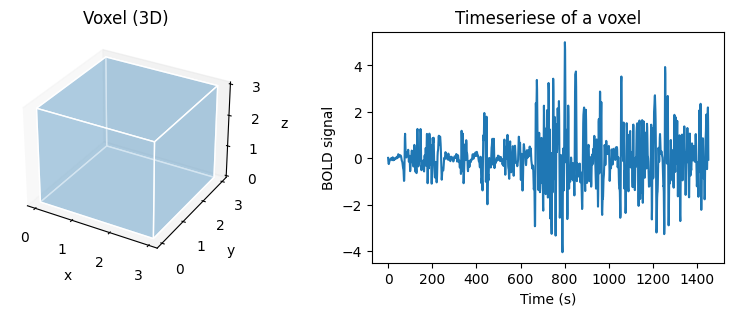

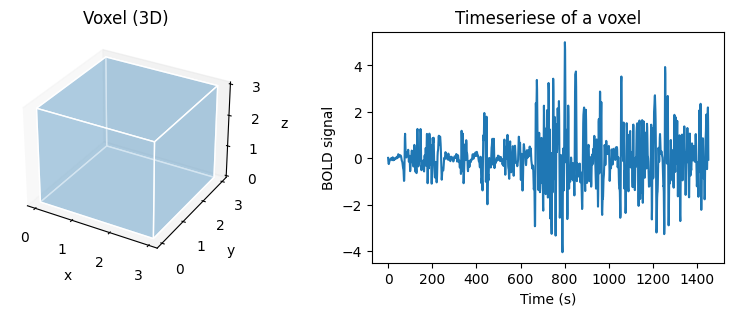

In [3]:
import pandas as pd
import numpy as np
from nilearn import datasets
from nilearn import maskers
import matplotlib.pyplot as plt

# change this to the location where you want the data to get downloaded
data_dir = './nilearn_data'

# Let's extract timeseries from one subject in a dataset
haxby_dataset = datasets.fetch_haxby(data_dir=data_dir)
haxby_func_filename = haxby_dataset.func[0]

# initialise a masker
brain_masker = maskers.NiftiMasker(
    smoothing_fwhm=6,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=0)

# Apply masker
brain_time_series = brain_masker.fit_transform(haxby_func_filename,
                                               confounds=None)
# Function for visualising 3D voxel
def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

# Initialise a figure
fig = plt.figure(figsize=(10,3))

# Visuallise the voxel
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.grid(False)
colors = np.array([[['#1f77b430']*1]*1]*1)
colors = explode(colors)
filled = explode(np.ones((1, 1, 1)))
x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

x[1::2, :, :] += 1
y[:, 1::2, :] += 1
z[:, :, 1::2] += 1

ax1.voxels(x, y, z, filled, facecolors=colors, edgecolors='white', shade=False)
plt.title("Voxel (3D)")


# Add timeseries to figure
# random voxel
voxel = 1
ax = fig.add_subplot(1, 2, 2)
ax.plot(brain_time_series[:, voxel])
ax.set_title("Timeseriese of a voxel")

plt.xlabel("Time (s)", fontsize = 10)
plt.ylabel("BOLD signal", fontsize= 10)

from myst_nb import glue
glue("voxel-timeseries-fig", fig, display=False)

```{glue:figure} voxel-timeseries-fig
:figwidth: 800px
:name: "voxel-timeseries-fig"
Illustration of a volume (voxel), size 3 mm x 3 mm x 3 mm, and the associated fMRI time course.
```

A 3D brain volume is formed by several thousand voxels, which are small units of volumes having a coordinate in x, y, z space.
In fMRI, for each voxel of the brain, we have several points of measurement of the activity over time, which forms what is called a time series or time course.
The time series reflects changes in neuronal activity over time indirectly through the blood delivering energy to activate the neurons, a mechanism called the haemodynamic response.
This activity creates a contrast between oxygenated and deoxygenated blood around a population of neurons detectable by the magnetic field, called the blood-oxygen-level-dependent (BOLD) signal.

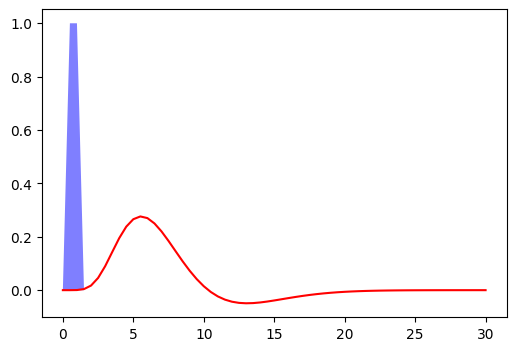

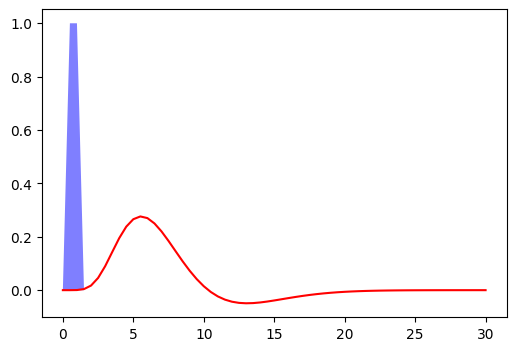

In [4]:
# To get an impulse response, we simulate a single event
# occurring at time t=0, with duration 1s.
frame_times = np.linspace(0, 30, 61)
onset, amplitude, duration = 0., 1., 1.
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)
stim = np.zeros_like(frame_times)
stim[(frame_times > onset) * (frame_times <= onset + duration)] = amplitude

# Now we plot the hrf
from nilearn.glm.first_level import compute_regressor
fig = plt.figure(figsize=(6, 4))

# obtain the signal of interest by convolution
signal, name = compute_regressor(
    exp_condition, 'glover', frame_times, con_id='main',
    oversampling=16)

# plot this
plt.fill(frame_times, stim, 'b', alpha=.5, label='stimulus')
plt.plot(frame_times, signal.T[0], 'r', label=name[0])

# Glue the figure
glue("hrf-fig", fig, display=False)

```{glue:figure} hrf-fig
:figwidth: 800px
:name: "hrf-fig"
Hemodynamic response to a unit pulse of one second duration, following the model proposed by {cite:p}`Glover_1999`. The code generated this figure is adopted from a [tutorial](https://nilearn.github.io/stable/auto_examples/04_glm_first_level/plot_hrf.html#sphx-glr-auto-examples-04-glm-first-level-plot-hrf-py) in Nilearn, et la. The figure is licenced under CC-BY.
```

## Neuroimaging data

Neuroimaging data does not have a tabular structure.
Instead, it has both spatial and temporal dependencies between successive data points.
That is, knowing _where_ and _when_ something was measured tells you information about the surrounding data points.

We also know that neuroimaging data contains a lot of noise that's not BOLD signal, such as head motion.
Since we don't think that these other noise sources are related to neuronal firing,
we often need to consider how we can make sure that our analyses are not driven by these noise sources.

These are all considerations that most machine learning software libraries are not designed to deal with!
Nilearn therefore plays a crucial role in bringing machine learning concepts to the neuroimaging domain.

To get a sense of the problem, the quickest method is to just look at some data.
You may have your own data locally that you'd like to work with.
Nilearn also provides access to several neuroimaging data sets and atlases (we'll talk about these a bit later).

These data sets (and atlases) are only accessible because research groups chose to make their collected data publicly available.
We owe them a huge thank you for this!
The data set we'll use today was originally collected by [Rebecca Saxe](https://mcgovern.mit.edu/profile/rebecca-saxe/)'s group at MIT and hosted on [OpenNeuro](https://openneuro.org/datasets/ds000228/versions/1.1.0).

The nilearn team preprocessed the data set with [fMRIPrep](https://fmriprep.readthedocs.io) and downsampled it to a lower resolution,
so it'd be easier to work with.
We can learn a lot about this data set directly [from the Nilearn documentation](https://nilearn.github.io/stable/modules/generated/nilearn.datasets.fetch_development_fmri.html).
For example, we can see that this data set contains over 150 children and adults watching a short Pixar film.
Let's download the first 30 participants.

In [5]:
# change this to the location where you want the data to get downloaded
data_dir = './nilearn_data'
# Now fetch the data
development_dataset = datasets.fetch_development_fmri(n_subjects=10,
                                                      data_dir=data_dir, 
                                                      reduce_confounds = False                                                      
                                                     )


Dataset created in ./nilearn_data/development_fmri


Dataset created in ./nilearn_data/development_fmri/development_fmri



 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


Now, this `development_dataset` object has several attributes which provide access to relevant information.
For example, `development_dataset.phenotypic` provides access to information about the participants, such as whether they were children or adults.
We can use `development_dataset.func` to access the functional MRI (fMRI) data.

Let's use [`nilearn.image.load_img`](https://nilearn.github.io/stable/modules/generated/nilearn.image.load_img.html) to learn a little bit about this data:

In [6]:
from nilearn import image

img = image.load_img(development_dataset.func[0])
img.shape

(50, 59, 50, 168)

This means that there are 168 volumes, each with a 3D structure of (50, 59, 50).

## Getting into the data: subsetting and viewing

Nilearn also provides many methods for plotting this kind of data.
For example, we can use [`nilearn.plotting.view_img`](https://nilearn.github.io/stable/modules/generated/nilearn.plotting.view_img.html) to launch at interactive viewer.
Because each fMRI run is a 4D time series (three spatial dimensions plus time),
we'll also need to subset the data when we plot it, so that we can look at a single 3D image.
Nilearn provides (at least) two ways to do this: with [`nilearn.image.index_img`](https://nilearn.github.io/stable/modules/generated/nilearn.image.index_img.html),
which allows us to index a particular frame--or several frames--of a time series,
and [`nilearn.image.mean_img`](https://nilearn.github.io/stable/modules/generated/nilearn.image.mean_img.html),
which allows us to take the mean 3D image over time.

Putting these together, we can interactively view the mean image of the first participant using:


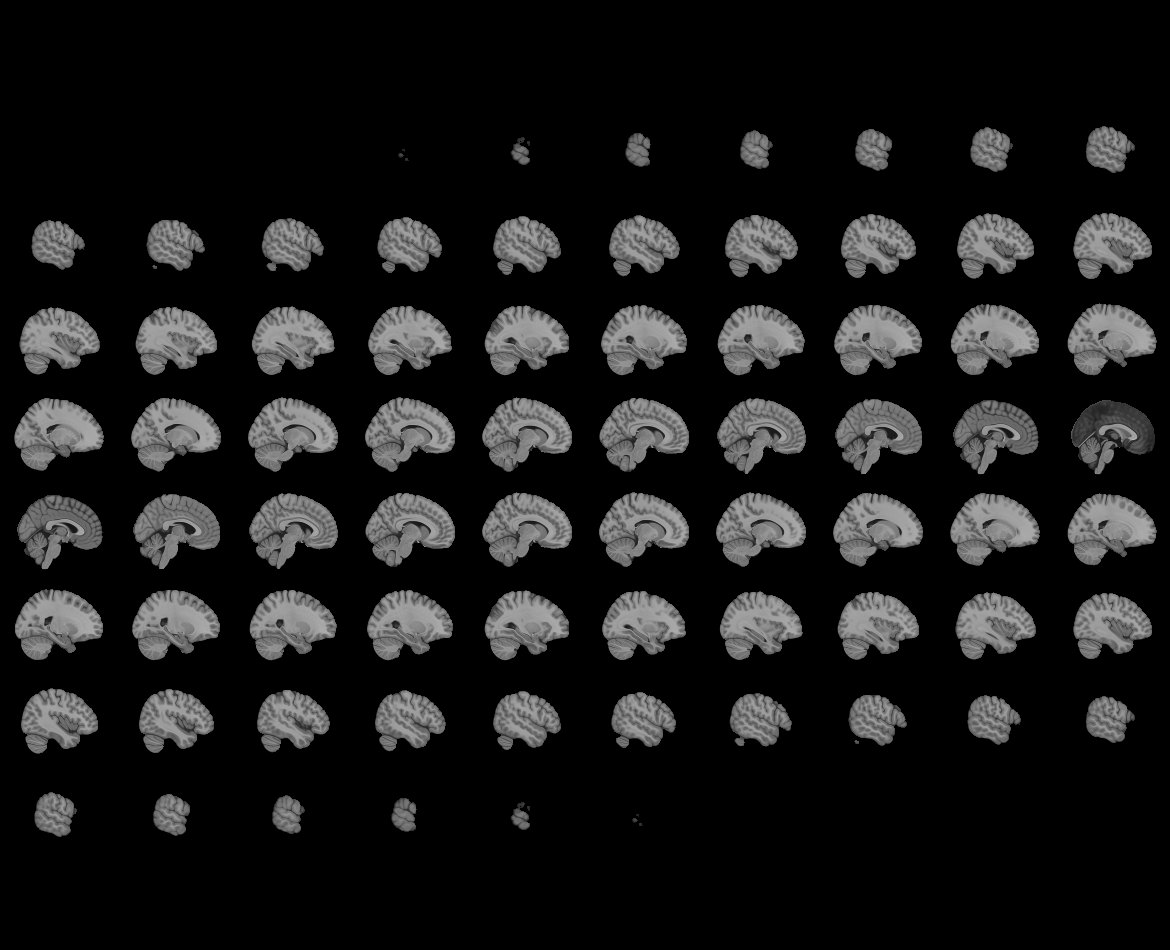
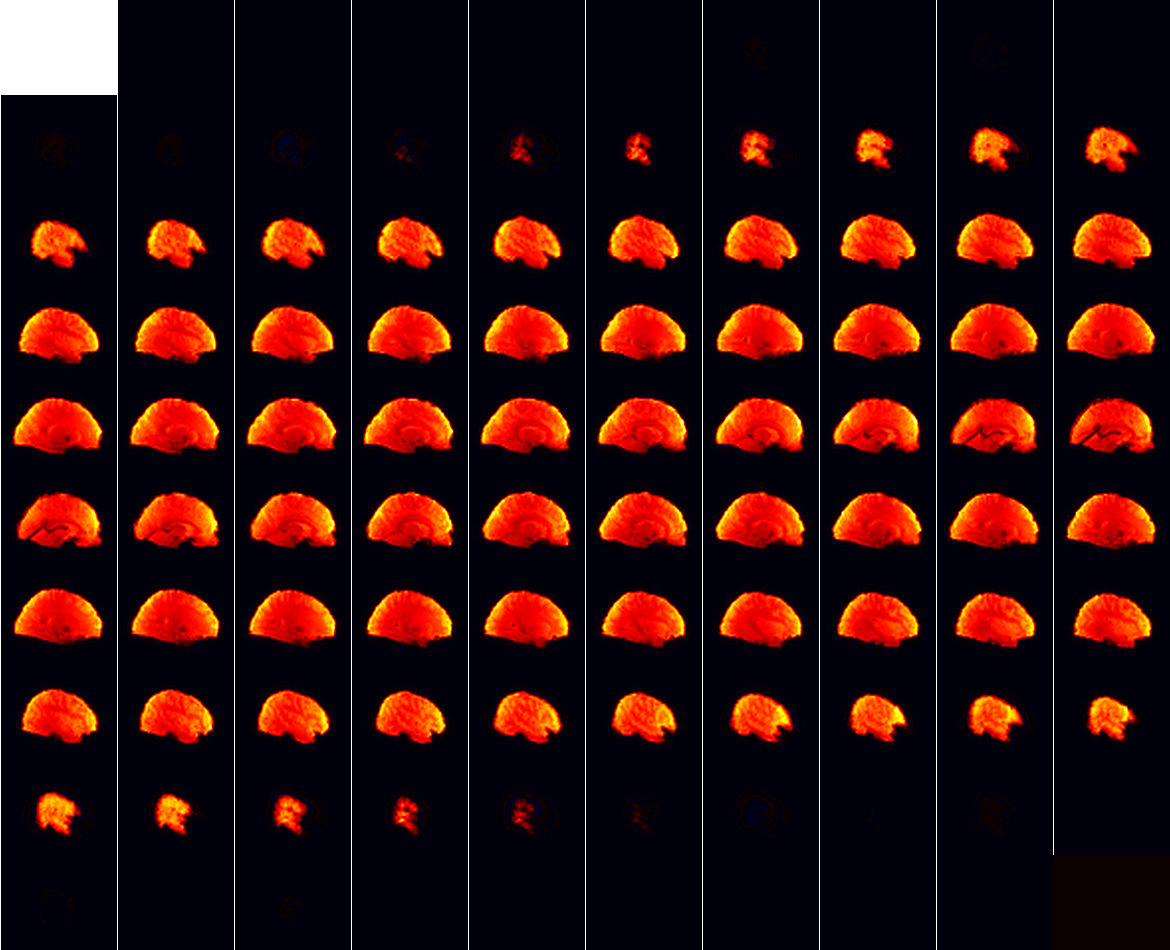

In [7]:
from nilearn import plotting

mean_image = image.mean_img(development_dataset.func[0])
plotting.view_img(mean_image, threshold=None)

## Extracting signal from fMRI volumes

As you can see, this data is decidedly not tabular!
What we'd like is to extract and transform meaningful features from this data,
and store it in a format that we can easily work with.
Importantly, we _could_ work with the full time series directly.
But we often want to reduce the dimensionality of our data in a structured way.
That is, we may only want to consider signal within certain learned or pre-defined regions of interest (ROIs),
while taking into account known sources of noise.
To do this, we'll use nilearn's Masker objects.
What are the masker objects ?
First, let's think about what masking fMRI data is doing:

```{figure} ../images/masking.jpg
---
height: 350px
name: masking
---
Masking fMRI data.
```

Essentially, we can imagine overlaying a 3D grid on an image.
Then, our mask tells us which cubes or “voxels” (like 3D pixels) to sample from.
Since our Nifti images are 4D files, we can’t overlay a single grid –
instead, we use a series of 3D grids (one for each volume in the 4D file),
so we can get a measurement for each voxel at each timepoint.

Masker objects allow us to apply these masks!
To start, we need to define a mask (or masks) that we'd like to apply.
This could correspond to one or many regions of interest.
Nilearn provides methods to define your own functional parcellation (using clustering algorithms such as _k-means_),
and it also provides access to other atlases that have previously been defined by researchers.

## Choosing regions of interest

Nilearn ships with several atlases commonly used in the field,
including the Schaefer atlas and the Harvard-Oxford atlas.

In this tutorial,
we'll use the MSDL (multi-subject dictionary learning; {cite:p}`Varoquaux_2011`) atlas,
which defines a set of _probabilistic_ ROIs across the brain.

In [8]:
msdl_atlas = datasets.fetch_atlas_msdl(data_dir=data_dir)

msdl_coords = msdl_atlas.region_coords
n_regions = len(msdl_coords)

print(f'MSDL has {n_regions} ROIs, part of the following networks :\n{np.unique(msdl_atlas.networks)}.')


Dataset created in ./nilearn_data/msdl_atlas



MSDL has 39 ROIs, part of the following networks :
['Ant IPS' 'Aud' 'Basal' 'Cereb' 'Cing-Ins' 'D Att' 'DMN' 'Dors PCC'
 'L V Att' 'Language' 'Motor' 'Occ post' 'R V Att' 'Salience' 'Striate'
 'Temporal' 'Vis Sec'].


 ...done. (1 seconds, 0 min)
Extracting data from ./nilearn_data/msdl_atlas/8eaecb9e05c478f565847000d9902a25/MSDL_rois.zip..... done.


It also provides us with easy ways to view these atlases directly.
Because MSDL is a probabilistic atlas, we can view it using:

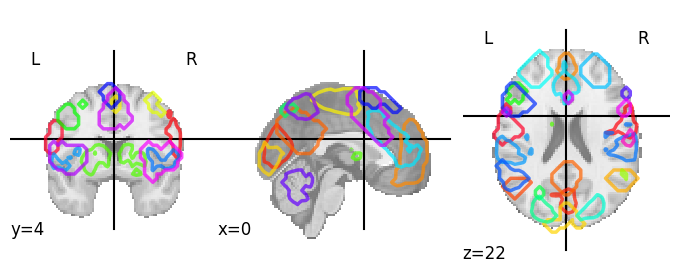

In [9]:
plotting.plot_prob_atlas(msdl_atlas.maps)

````{admonition} Different type of brain parcellation schemes
:class: note

There are various ways of defining brain parcels.
Largely we can classify them in two ways:

- Functional vs anatomical

    - Anatomical atlases use structural land marks to separate regions. Example: [Harvard-Oxford atlas](https://nilearn.github.io/stable/modules/generated/nilearn.datasets.fetch_atlas_harvard_oxford.html)
    - Functional atlases define regions based on the organisation of fMRI signal, such as functional connectivity. Example: [Schaefer atlas](https://nilearn.github.io/stable/modules/generated/nilearn.datasets.fetch_atlas_schaefer_2018.html)

- Soft vs hard

    - Soft, or probabilistic parcels use contiunous, non-zero values to define regions.
    Example: [Difumo (functional)](https://nilearn.github.io/stable/modules/generated/nilearn.datasets.fetch_atlas_difumo.html#nilearn.datasets.fetch_atlas_difumo),
    [Hammersmith (anatomical)](https://pubmed.ncbi.nlm.nih.gov/12874777/)
    - Hard parcels have rigid boundaries. Example: [BASC (functional)](https://nilearn.github.io/stable/modules/generated/nilearn.datasets.fetch_atlas_basc_multiscale_2015.html#nilearn.datasets.fetch_atlas_basc_multiscale_2015)

It's important to understand the method used for constructing the atlas of choice.
For example, using a anatomical atlas to extract signal from functional data might not be the best thing.
To find out more, [watch this lecture from Brainhack School by Dr Pierre Bellec on brain parcellation in fMRI](https://www.youtube.com/watch?v=7uMVRebuDZo).
````

## A quick side-note on the NiftiMasker zoo

We'd like to supply these ROIs to a Masker object.
All Masker objects share the same basic structure and functionality,
but each is designed to work with a different kind of ROI.

The canonical [`nilearn.maskers.NiftiMasker`](https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiMasker.html) works well if we want to apply a single mask to the data,
like a single region of interest.

But what if we actually have several ROIs that we'd like to apply to the data all at once?
If these ROIs are non-overlapping,
as in "hard" or deterministic parcellations,
then we can use [`nilearn.maskers.NiftiLabelsMasker`](https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiLabelsMasker.html).
Because we're working with "soft" or probabilistic ROIs,
we can instead supply these ROIs to [`nilearn.maskers.NiftiMapsMasker`](https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiMapsMasker.html).

```{admonition} Further reading on Maskers
:class: note
For a full list of the available Masker objects,
see [the Nilearn documentation](https://nilearn.github.io/stable/modules/maskers.html).

To learn more about the concept, `nilearn` provides a great [tutorial](https://nilearn.github.io/stable/manipulating_images/masker_objects.html).
```

## Applying a Masker object

We can supply our MSDL atlas-defined ROIs to the `NiftiMapsMasker` object,
along with resampling, filtering, and detrending parameters.

In [10]:
masker = maskers.NiftiMapsMasker(
    msdl_atlas.maps, resampling_target="data", detrend=True).fit()

One thing you might notice from the above code is that immediately after defining the masker object,
we call the `.fit` method on it.
This method may look familiar if you've previously worked with scikit-learn estimators!

You'll note that we're not supplying any data to this `.fit` method;
that's because we're fitting the Masker to the provided ROIs, rather than to our data.

## Dimensions, dimensions

We can use this fitted masker to transform our data.

In [11]:
roi_time_series = masker.transform(development_dataset.func[0])
roi_time_series.shape

(168, 39)

If you remember, when we first looked at the data, its original dimensions were (50, 59, 50, 168).
Now, it has a shape of (168, 39).
What happened?!

Rather than providing information on every voxel within our original 3D grid,
we're now only considering those voxels that fall in our 39 regions of interest provided by the MSDL atlas and aggregating across voxels within those ROIS.
This reduces each 3D volume from a dimensionality of (50, 59, 50) to just 39,
for our 39 provided ROIs.

You'll also see that the dimensions "flipped."
That is, we've transposed the matrix such that time is now the first rather than second dimension.
This follows the scikit-learn convention that rows are _samples_
and columns are _features_ in a data matrix.

```{figure} ../images/samples-features.png
---
height: 250px
name: samples-features
---
The scikit-learn conventions for feature and target matrices.
From Jake VanderPlas's _Python Data Science Handbook_.
```

One of the nice things about working with nilearn is that it will impose this convention for you,
so you don't accidentally flip your dimensions when using a scikit-learn model!

## Creating and viewing a connectome

Scientists have found that some cognitive functions involve the activity of neurons from an isolated region, and sometimes different regions of the brain interact together to perform a task.
This functional integration leads to a description of the functional brain as a network.
Formally, the co-activation of different time series is called functional connectivity.

The simplest and most commonly used kind of functional connectivity is pairwise correlation between ROIs.

We can estimate it using [`nilearn.connectome.ConnectivityMeasure`](https://nilearn.github.io/stable/modules/generated/nilearn.connectome.ConnectivityMeasure.html).

In [12]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([roi_time_series])[0]

We can then plot this functional connectivity matrix:

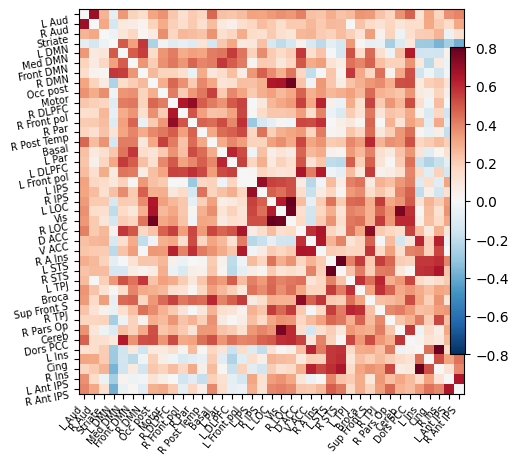

In [13]:
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, labels=msdl_atlas.labels,
                     vmax=0.8, vmin=-0.8, colorbar=True)

Or view it as an embedded connectome:

In [14]:
plotting.view_connectome(correlation_matrix, edge_threshold=0.2,
                         node_coords=msdl_atlas.region_coords)

## Accounting for noise sources

As we've already seen,
maskers also allow us to perform other useful operations beyond just masking our data.
One important processing step is correcting for measured signals of no interest (e.g., head motion).
Our `development_dataset` also includes several of these signals of no interest that were generated during fMRIPrep pre-processing.
We can access these with the `confounds` attribute,
using `development_dataset.confounds`.

Let's quickly check what these look like for our first participant:

In [15]:
pd.read_table(development_dataset.confounds[0]).head()

csf  white_matter  global_signal  std_dvars      dvars  \
0  439.699409    451.645460     525.387206   0.000000   0.000000   
1  439.471640    451.103437     525.155030   0.940416  14.937284   
2  439.744498    450.981505     525.324735   0.885710  14.068359   
3  440.772620    450.600261     525.606646   0.864385  13.729636   
4  440.115442    450.678959     525.656775   0.830847  13.196932   

   framewise_displacement  t_comp_cor_00  t_comp_cor_01  t_comp_cor_02  \
0                0.000000      -0.093142      -0.047009       0.110108   
1                0.055543      -0.091190      -0.075796       0.084680   
2                0.054112      -0.051778      -0.012647      -0.014665   
3                0.057667      -0.025552       0.004938      -0.044833   
4                0.051438      -0.032434      -0.021743       0.003173   

   t_comp_cor_03  ...  cosine00  cosine01  cosine02  cosine03   trans_x  \
0      -0.132180  ...  0.109104  0.109090  0.109066  0.109033 -0.000233   
1      -0.026517  ...  0.109066  0.108937  0.108723  0.108423 -0.006187   
2       0.003982  ...  0.108990  0.108632  0.108038  0.107207 -0.000227   
3       0.077124  ...  0.108875  0.108176  0.107012  0.105391  0.002492   
4       0.063508  ...  0.108723  0.107567  0.105651  0.102986 -0.000226   

    trans_y   trans_z     rot_x     rot_y     rot_z  
0 -0.076885  0.062321  0.000732  0.000352  0.000841  
1 -0.078395  0.056773  0.000112  0.000187  0.000775  
2 -0.069893  0.083102  0.000143  0.000364  0.000716  
3 -0.074707  0.060337  0.000202  0.000818  0.000681  
4 -0.084204  0.085079  0.000183  0.000548  0.000682  

[5 rows x 28 columns]

We can see that there are several different kinds of noise sources included!
This is actually a subset of all possible fMRIPrep generated confounds that the Nilearn developers have pre-selected.
For most analyses, this list of confounds is reasonable, so we'll use these Nilearn provided defaults.

````{admonition} New coming feature in NiLearn about confounds
:class: tip

We could access the full list by passing the argument `reduce_confounds=False` to our original call downloading the `development_dataset`.

```{warning}
Never pass the full fMRIPrep confounds to the denoising function.
```

For your own analyses, make sure to check which confounds you're using!
In the recent version of nilearn, a new module `nilearn.interfaces.fmriprep` has been added.
We implemented function [`load_confounds`](https://nilearn.github.io/stable/modules/generated/nilearn.interfaces.fmriprep.load_confounds.html)
and [`load_confounds_strategy`](https://nilearn.github.io/stable/modules/generated/nilearn.interfaces.fmriprep.load_confounds_strategy.html)
to help you select confound variables based on existing literature and fMRIPrep documentations.
For more information, please refer to the
[this nilearn document](https://nilearn.github.io/stable/auto_examples/03_connectivity/plot_signal_extraction.html#sphx-glr-auto-examples-03-connectivity-plot-signal-extraction-py).
````

Importantly, we can pass these confounds directly to our masker object:

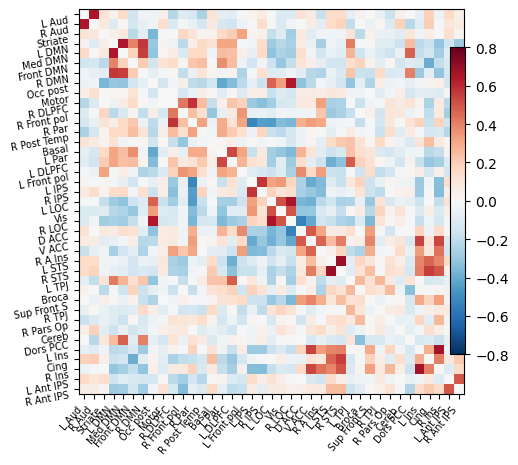

In [16]:
corrected_roi_time_series = masker.transform(
    development_dataset.func[0], confounds=development_dataset.confounds[0])
corrected_correlation_matrix = correlation_measure.fit_transform(
    [corrected_roi_time_series])[0]
np.fill_diagonal(corrected_correlation_matrix, 0)
plotting.plot_matrix(corrected_correlation_matrix, labels=msdl_atlas.labels,
                     vmax=0.8, vmin=-0.8, colorbar=True)

As before, we can also view this functional connectivity matrix as a connectome:

In [17]:
plotting.view_connectome(corrected_correlation_matrix, edge_threshold=0.2,
                         node_coords=msdl_atlas.region_coords)

In both the matrix and connectome forms,
we can see a big difference when including the confounds!
This is an important reminder to make sure that your data are cleaned of any possible sources of noise _before_ running a machine learning analysis.
Otherwise, you might be classifying participants on e.g. amount of head motion rather than a feature of interest!


## References

```{bibliography}
:filter: docname in docnames
```